In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../tools/")

In [2]:
from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data

In [3]:
# Task 1: Select what features you'll use.
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
features_list = ['salary','bonus'] # You will need to use more features

In [4]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [17]:
print(data_dict)

{'METTS MARK': {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}, 'BAXTER JOHN C': {'salary': 267102, 'to_messages': 'NaN', 'deferral_payments': 1295738, 'total_payments': 5634343, 'exercised_stock_options': 6680544, 'bonus': 1200000, 'restricted_stock': 3942714, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 10623258, 'expenses': 11200, 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 2660303, 'from_this_person_to_poi': 'NaN', 'poi': False, 'direct

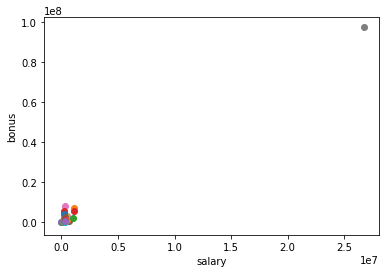

In [5]:
# Visualize the data
def visualize():
    data = featureFormat(data_dict,features_list)
    for point in data:
        salary = point[0]
        bonus = point[1]
        plt.scatter( salary, bonus )
    plt.xlabel("salary")
    plt.ylabel("bonus")
    plt.show()

    # labels,features = targetFeatureSplit(data)
    # plt.scatter(labels,features)
    # plt.xlabel("POI")
    # plt.ylabel("Salary")
    # plt.show()
visualize()

(26704229, 'TOTAL')


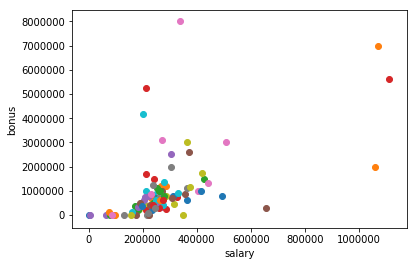

In [6]:
#Finding the outlier
max_salary,max_key = 0,''
for key,value in data_dict.items():
    if value['salary'] > max_salary and value['salary']<>'NaN':
        max_salary, max_key = value['salary'],key
        
print(max_salary,max_key)
#Removing the outlier
data_dict.pop('TOTAL')

#Visualize after removing the outlier
visualize()

In [7]:
#There are few outliers still there. But we cannot remove them, they might be the actual people involved in the fraud.
#We'll see who are they.
outliers = []
for key in data_dict:
    sal = data_dict[key]['salary']
    if sal<>'NaN':
        outliers.append((key,int(sal)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
print(outliers_final)
        

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


In [15]:
# sys.path.append("../Enron_Corpus/Outlier")
# from outlier_removal_regression import outlierRemovalRegression
# labels,features = targetFeatureSplit(data)
# outlierRemovalRegression(features,labels)

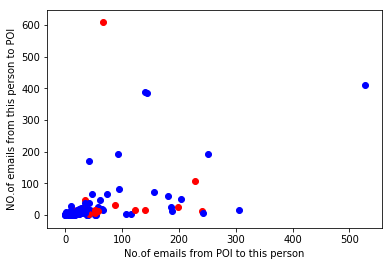

In [8]:
#Feature processing
#Selecting two features from the existing data.
features_list = ['poi','from_poi_to_this_person','from_this_person_to_poi']
data = featureFormat(data_dict,features_list)

for point in data:
    from_poi = point[1]
    to_poi = point[2]
    if point[0]==1:
        plt.scatter(from_poi,to_poi,c="r")
    else:
        plt.scatter(from_poi,to_poi, c='b')

plt.xlabel("No.of emails from POI to this person")
plt.ylabel("NO.of emails from this person to POI")
plt.show()

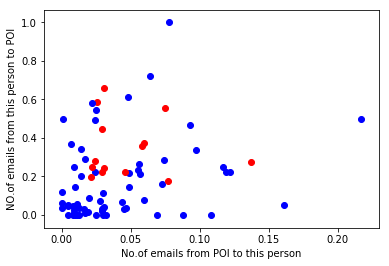

In [35]:
#There is no strong patter here that differentiate POI from non-POI.
#Lets use fraction of them.
def fraction_feature(new_feature,key,norm):
    
    for emp in data_dict.keys():
        
        if data_dict[emp][key]<>'NaN' and data_dict[emp][norm]<>'NaN':
            div = float(data_dict[emp][key])/data_dict[emp][norm]
            data_dict[emp][new_feature] = round(div,3)
        else:
            data_dict[emp][new_feature] = 0.0

fraction_feature("fraction_from_poi_email","from_poi_to_this_person","to_messages")
fraction_feature("fraction_to_poi_email","from_this_person_to_poi","from_messages")

#new features
features_list = ['poi',"fraction_from_poi_email","fraction_to_poi_email"]
data = featureFormat(data_dict,features_list)

for point in data:
    from_poi = point[1]
    to_poi = point[2]
    if point[0]==1:
        plt.scatter(from_poi,to_poi,c="r")
    else:
        plt.scatter(from_poi,to_poi, c='b')

plt.xlabel("No.of emails from POI to this person")
plt.ylabel("NO.of emails from this person to POI")
plt.show()